### **Projet - Estimation du prix d'un appartement à Paris**
- Vitor Biscuola
- Linkedin : https://fr.linkedin.com/in/vitor-biscuola


Remerciements / Sources
- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 
- https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- Data source : https://www.data.gouv.fr/en/datasets/demandes-de-valeurs-foncieres/

In [0]:
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 
# https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [564]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from math import e
import xgboost

In [566]:
df = pd.read_csv('/content/drive/My Drive/Data Science/DataSet_ValeurFonciere_v2.txt', sep='|', decimal=',')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [567]:
df.head()

,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Type local,Surface bati,Nb pieces,Surface terrain
0,6/4/2018 00:00:00,Vente,454100.0,41.0,BD,3030,DU JEU DE PAUME,34000.0,MONTPELLIER,34,172,Appartement,123.0,4.0,NaN
1,23/4/2019 00:00:00,Vente,1090000.0,34.0,RUE,7263,PERGOLESE,75016.0,PARIS 16,75,116,Appartement,87.0,4.0,NaN
2,17/4/2019 00:00:00,Vente,900000.0,39.0,RUE,2817,DOCTEUR BLANCHE,75016.0,PARIS 16,75,116,Appartement,85.0,3.0,NaN
3,15/4/2019 00:00:00,Echange,6000.0,125.0,AV,6626,MOZART,75016.0,PARIS 16,75,116,Appartement,10.0,1.0,NaN
4,19/3/2018 00:00:00,Vente,225700.0,45.0,RUE,5105,SAINT GUILHEM,34000.0,MONTPELLIER,34,172,Appartement,67.0,3.0,NaN


In [568]:
print(df.dtypes)

Date mutation        object
Nature mutation      object
Valeur fonciere     float64
No voie             float64
Type de voie         object
Code voie            object
Voie                 object
Code postal         float64
Commune              object
Code departement     object
Code commune          int64
Type local           object
Surface bati        float64
Nb pieces           float64
Surface terrain     float64
dtype: object


**Préparation des données**

In [0]:
# filtre sur le département 75 afin de prendre en compte uniquement les apparts parisiens
df = df[df['Code departement']==75]

In [0]:
# Dans notre modèle, on s'intéresse uniquement aux ventes. Du coup, on supprimera toutes les valeurs
# différentes de 'Vente' et 'Vente en l'état futur d'achèvement' (qui correspond aux ventes sur plan)
df = df[df['Nature mutation'].isin(["Vente","Vente en l'état futur d'achèvement"])]

In [0]:
# suppression des colonnes
# No voie, Type de voie, Code voie et Voie sont des données trop spécifiques à une adresse précise.
# La variable de géolocalisation qu'on utilisera sera l'arrondissement (Commune). Dans ce contexte
# on peut même supprimer la colonne Code postal et Code commune
# On supprime également la Date mutation car notre historique n'est pas très significatif (moins de 2 ans)
# On supprime le Code departement car il y a une seule valeur possible (75) et de même avec Type local car 
# nous avons une seule valeur possible (Appartement)
df = df.drop(['Date mutation','No voie','Type de voie','Code voie','Voie','Code postal','Code commune','Code departement',
              'Type local'],axis='columns')

In [572]:
df.describe()

,Valeur fonciere,Surface bati,Nb pieces,Surface terrain
count,4.328800e+04,43311.000000,43311.000000,300.000000
mean,7.998807e+05,54.426959,2.425065,520.436667
std,1.373425e+07,43.014927,1.337940,712.248683
min,1.000000e+00,2.000000,0.000000,29.000000
25%,2.400000e+05,28.000000,1.000000,171.000000
50%,3.910000e+05,43.000000,2.000000,281.000000
75%,6.600000e+05,68.000000,3.000000,548.250000
max,1.249132e+09,1500.000000,26.000000,6173.000000


In [573]:
# analyse des données manquantes
# on calcule le nombre total de valeurs nulles et le pourcentage par rapport au nombre total d'enregistrements
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Surface terrain,43012,0.993074
Valeur fonciere,24,0.000554
Nb pieces,1,0.000023
Surface bati,1,0.000023
Commune,0,0.000000
Nature mutation,0,0.000000


In [0]:
# On voit que la 'Surface terrain' est nulle pour la grosse majorité des enregistrements -> on la supprime
df = df.drop(['Surface terrain'], axis='columns')

In [0]:
# On supprime les lignes avec au moins une valeur manquante
df = df.dropna()

In [576]:
# On vérifie si effectivement il ne reste plus des valeurs nulles
df.isnull().any()

Nature mutation    False
Valeur fonciere    False
Commune            False
Surface bati       False
Nb pieces          False
dtype: bool

In [577]:
# On voit des Nb pieces == 0. Vérifions s'il y aurait beaucoup de cas comme ça
df[df['Nb pieces']==0].shape

(44, 5)

In [0]:
# On supprime ces valeurs
df = df[df['Nb pieces']>0]

In [579]:
df.head()

,Nature mutation,Valeur fonciere,Commune,Surface bati,Nb pieces
225859,Vente,1196000.0,PARIS 01,112.0,3.0
225860,Vente,1570490.0,PARIS 03,104.0,3.0
225861,Vente,5400.0,PARIS 03,21.0,1.0
225862,Vente,230000.0,PARIS 03,26.0,1.0
225863,Vente,955750.0,PARIS 08,80.0,3.0


In [580]:
df.describe()

,Valeur fonciere,Surface bati,Nb pieces
count,4.324300e+04,43243.000000,43243.000000
mean,8.004653e+05,54.458317,2.427399
std,1.374138e+07,43.024027,1.336453
min,1.000000e+00,3.000000,1.000000
25%,2.400000e+05,28.000000,1.000000
50%,3.916000e+05,43.000000,2.000000
75%,6.600000e+05,68.000000,3.000000
max,1.249132e+09,1500.000000,26.000000


In [581]:
# On voit que la valeur minimale de Valeur foncière est 1
# On voit que la valeur maximale de Valeur foncière est largement supérieure à la moyenne et le quartile 75%.
# On va donc exclure les outliers avec la méthode IQR (interquartile range)
q1 = np.quantile(df["Valeur fonciere"], 0.25) 
q3 = np.quantile(df["Valeur fonciere"], 0.75)
IQR = q3 - q1
seuil_min = q1 - 1.5*IQR
seuil_max = q3 + 1.5*IQR
print(" IQR : {}\n Seuil Min : {}\n Seuil Max : {}".format(IQR,seuil_min,seuil_max))

 IQR : 420000.0
 Seuil Min : -390000.0
 Seuil Max : 1290000.0


In [0]:
# Le seuil min est inférieur à 0. Je vais quand même exclure toutes les valeurs inférieures à 10 000
# car un appartement vendu à moins de 10 000 euros à Paris n'est pas normal
# Le seuil max me paraît pas suffisamment élevé. C'est tout à fait possible de trouver des appartements
# dont la valeur est supérieure au seuil max à Paris. Je vais donc limiter les valeurs à 5 000 000
df = df[df['Valeur fonciere']>10000]
df = df[df['Valeur fonciere']<5000000]

In [583]:
df.describe()

,Valeur fonciere,Surface bati,Nb pieces
count,4.224600e+04,42246.000000,42246.000000
mean,5.549033e+05,53.591015,2.406973
std,5.260050e+05,39.688099,1.293116
min,1.020000e+04,3.000000,1.000000
25%,2.450000e+05,28.000000,1.000000
50%,3.950000e+05,43.000000,2.000000
75%,6.600000e+05,67.000000,3.000000
max,4.950000e+06,481.000000,20.000000


In [0]:
# On va garder ce dataframe traité pour qu'on puisse l'utiliser pour d'autres modèles
df_clean = df.copy()

**Benchmark : Regression Linéaire Simple**

In [0]:
# Benchmark : on va effectuer une regression linéaire simple en se basant sur la surface bati.

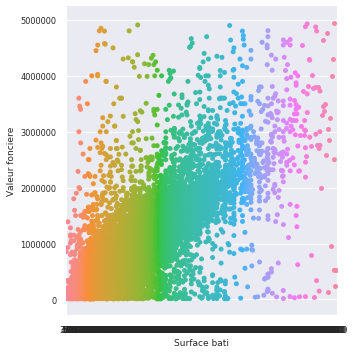

In [586]:
# Tout d'abord, on visualise la correlation
sns.catplot(x="Surface bati", y="Valeur fonciere", data = df)

In [0]:
# Séparation des données en variables explicatives X et target y 
X = df[["Surface bati"]]
y = df[["Valeur fonciere"]]

In [0]:
# Division du dataset en train et un test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [589]:
# Création du modèle 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [590]:
# Vérification du score et de l'overfitting 
print(" Score de Train : {}\n Score de Test : {}".format(regressor.score(X_train, y_train), regressor.score(X_test, y_test)))

 Score de Train : 0.6632406933555979
 Score de Test : 0.6522052181912898


---> Le train est comparable au test donc pas d'overfitting.

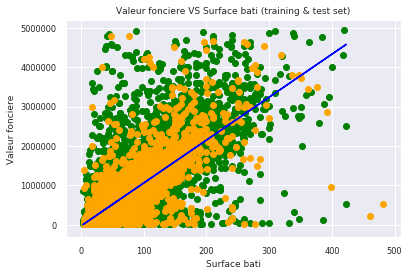

In [591]:
# Visualisation des trains & data sets et de la regression effectuée
plt.scatter(X_train, y_train, color="green")
plt.scatter(X_test, y_test, color="orange")
plt.plot(X_train, regressor.predict(X_train), color="blue")
plt.title("Valeur fonciere VS Surface bati (training & test set)")
plt.xlabel("Surface bati")
plt.ylabel("Valeur fonciere")
plt.show()

In [592]:
# Voici le coef et intercept de notre regression linéaire
print(" Coef : {}\n Intercept : {}".format(regressor.coef_[0], regressor.intercept_))

 Coef : [10890.79183419]
 Intercept : [-26979.07824995]


**Regression Linéaire Simple : Test de Normalité**

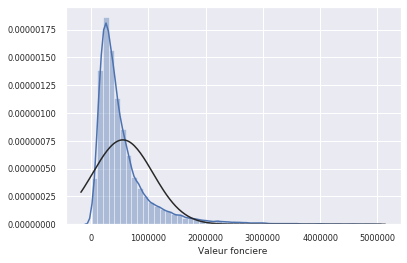

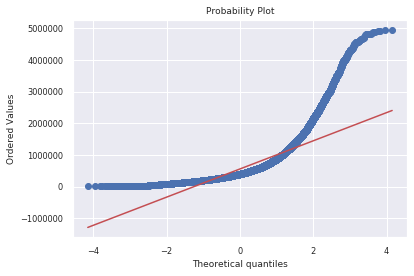

In [593]:
# On va vérifier si la valeur fonciere et la surface bati ont des distributions normales
# histogram and normal probability plot - Valeur fonciere
sns.distplot(df['Valeur fonciere'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Valeur fonciere'], plot=plt)

In [0]:
# On voit bien que 'Valeur fonciere' n'a pas une distribution normale
# Essayons de faire une transformation log
df['Valeur fonciere'] = np.log(df['Valeur fonciere'])

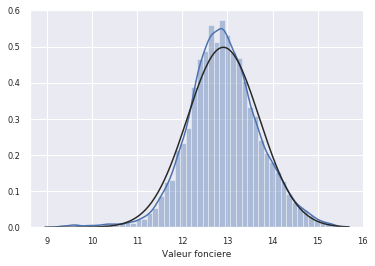

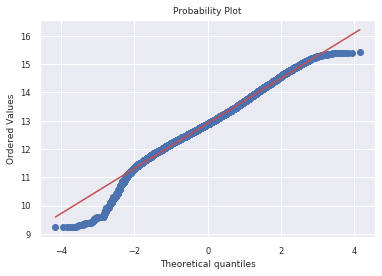

In [595]:
# transformed histogram and normal probability plot - Valeur fonciere
sns.distplot(df['Valeur fonciere'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Valeur fonciere'], plot=plt)

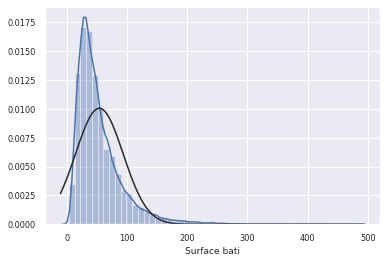

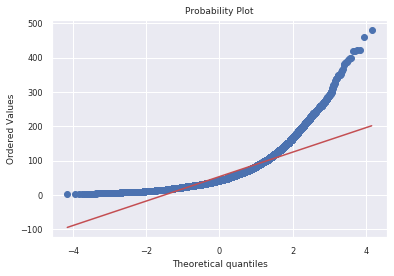

In [596]:
# C'est beaucoup mieux ! On fait le même exercice pour la Surface bati
sns.distplot(df['Surface bati'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Surface bati'], plot=plt)

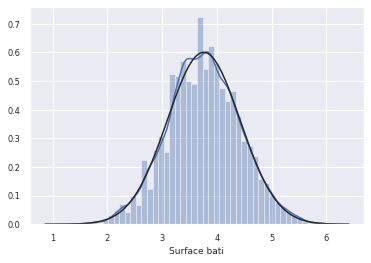

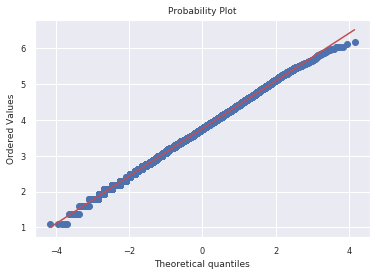

In [597]:
# On voit bien que 'Surface bati' n'a pas une distribution normale. Essayons de faire une transformation log
df['Surface bati'] = np.log(df['Surface bati'])

sns.distplot(df['Surface bati'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Surface bati'], plot=plt)

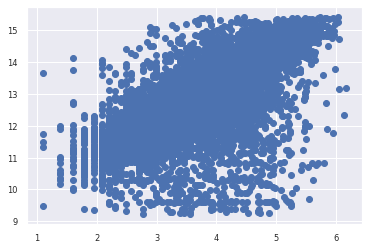

In [598]:
# Tout d'abord, on visualise la correlation
plt.scatter(df['Surface bati'], df['Valeur fonciere'],);

Older versions of this scatter plot (previous to log transformations), had a conic shape. As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.

In [0]:
# It's beautiful! Essayons de faire une regression linéaire 
# Séparation des données en variables explicatives X et target y 
X = df[["Surface bati"]]
y = df[["Valeur fonciere"]]

In [0]:
# Division du dataset en train et test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [601]:
# Création du modèle 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [602]:
# Vérifcation du score et de l'overfitting 
print(" Score de Train : {}\n Score de Test : {}".format(regressor.score(X_train, y_train), regressor.score(X_test, y_test)))

 Score de Train : 0.656133702997457
 Score de Test : 0.6569648638129588


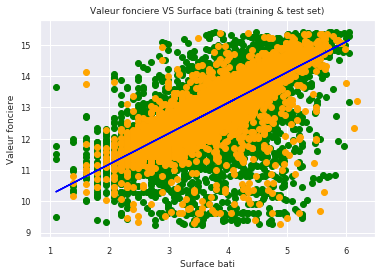

In [603]:
# Visualize our Training Set and Test Set
plt.scatter(X_train, y_train, color="green")
plt.scatter(X_test, y_test, color="orange")
plt.plot(X_train, regressor.predict(X_train), color="blue")
plt.title("Valeur fonciere VS Surface bati (training & test set)")
plt.xlabel("Surface bati")
plt.ylabel("Valeur fonciere")
plt.show()

In [604]:
# Voici le coef et intercept de notre regression linéaire
print(" Coef : {}\n Intercept : {}".format(regressor.coef_[0], regressor.intercept_))

 Coef : [0.97912814]
 Intercept : [9.22695291]


In [605]:
# Voici l'équation. Vu qu'on a effectué des transformations log, il faut l'adapter pour qu'on puisse
# rentrer des valeurs sans transformation log et obtenir une valeur sans transformation log
X = 30 #Surface
y_pred = e**(regressor.coef_[0]*np.log(X)+regressor.intercept_)
print(" Surface : {}\n Prix Estimé : {}".format(X, y_pred[0]))

 Surface : 30
 Prix Estimé : 284122.5581110927


**Regression Lineaire Multiple**

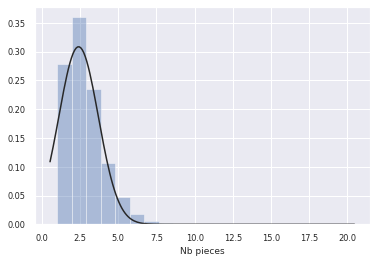

<Figure size 432x288 with 0 Axes>

In [606]:
# Nous allons intégrer toues les variables dans notre modèle
# Analysons la variable Nb pièces
sns.distplot(df['Nb pieces'], bins = 20, hist=True, kde=False, fit=norm);
fig = plt.figure()

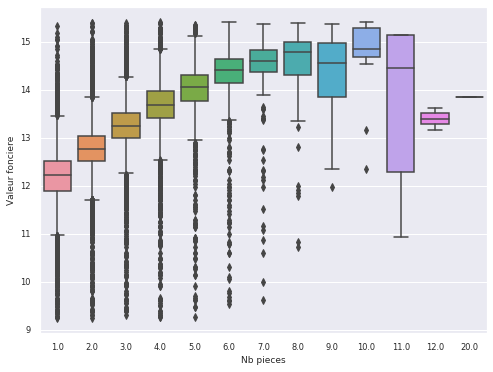

In [607]:
# Analysons la variable Nb pièces - box plot
var = 'Nb pieces'
data = pd.concat([df['Valeur fonciere'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Valeur fonciere", data=data)

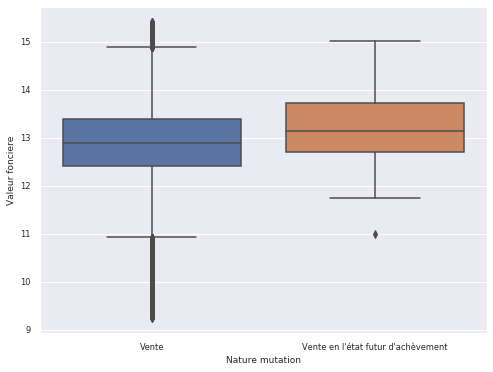

In [608]:
# Analysons la variable Nb pièces - box plot
var = 'Nature mutation'
data = pd.concat([df['Valeur fonciere'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Valeur fonciere", data=data)

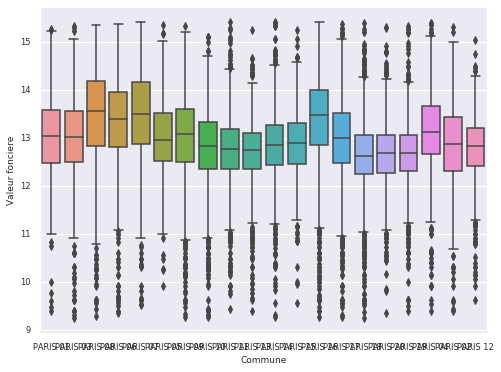

In [609]:
# Analysons la variable Commune - box plot
var = 'Commune'
data = pd.concat([df['Valeur fonciere'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Valeur fonciere", data=data)

In [610]:
# Création des variables Dummy 
df = pd.get_dummies(df, drop_first=True)
df.head()

,Valeur fonciere,Surface bati,Nb pieces,Nature mutation_Vente en l'état futur d'achèvement,Commune_PARIS 02,Commune_PARIS 03,Commune_PARIS 04,Commune_PARIS 05,Commune_PARIS 06,Commune_PARIS 07,Commune_PARIS 08,Commune_PARIS 09,Commune_PARIS 10,Commune_PARIS 11,Commune_PARIS 12,Commune_PARIS 13,Commune_PARIS 14,Commune_PARIS 15,Commune_PARIS 16,Commune_PARIS 17,Commune_PARIS 18,Commune_PARIS 19,Commune_PARIS 20
225859,13.994493,4.718499,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225860,14.266898,4.644391,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225862,12.345835,3.258097,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225863,13.770252,4.382027,3.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
225864,13.135872,3.806662,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Renommer les variables
df.columns = ['Valeur fonciere', 'Surface bati', 'Nb pieces',
       'Vente sur plan',
       'PARIS 02', 'PARIS 03', 'PARIS 04',
       'PARIS 05', 'PARIS 06', 'PARIS 07',
       'PARIS 08', 'PARIS 09', 'PARIS 10',
       'PARIS 11', 'PARIS 12', 'PARIS 13',
       'PARIS 14', 'PARIS 15', 'PARIS 16',
       'PARIS 17', 'PARIS 18', 'PARIS 19',
       'PARIS 20']

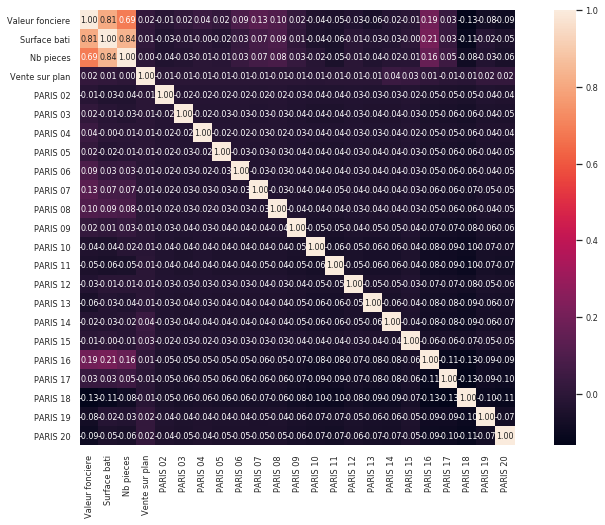

In [612]:
# matrice de corrélation
corrmat = df.corr()
cols=corrmat.index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=0.75)
f, ax = plt.subplots(figsize=(14, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [0]:
# La Surface bati et le nb pieces sont très correlés. Pour l'instant on garde les 2 variables
# On applique la regression avec toutes les variables

In [0]:
# Séparation de X & y 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [0]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
X = sc_x.fit_transform(X)

In [0]:
# Train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [617]:
# Création du modèle 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [618]:
# Vérifcation du score et de l'overfitting 
print(" Score de Train : {}\n Score de Test : {}".format(regressor.score(X_train, y_train), regressor.score(X_test, y_test)))

 Score de Train : 0.6831435256732943
 Score de Test : 0.6795880811038051


On voit une **amélioration** du modèle !

In [619]:
# Classement des features par importance 
feature_importance = pd.DataFrame({"features": ['Surface bati', 'Nb pieces', 'Vente sur plan',
                                         'PARIS 02', 'PARIS 03', 'PARIS 04', 'PARIS 05', 'PARIS 06', 'PARIS 07',
                                         'PARIS 08', 'PARIS 09', 'PARIS 10', 'PARIS 11', 'PARIS 12', 'PARIS 13',
                                         'PARIS 14', 'PARIS 15', 'PARIS 16', 'PARIS 17', 'PARIS 18', 'PARIS 19',
                                         'PARIS 20'
                                         ], 
                                   "values":regressor.coef_,
                                "absolute values":abs(regressor.coef_),})

feature_importance.sort_values(["absolute values"], ascending=False)


,features,values,absolute values
0,Surface bati,0.614121,0.614121
19,PARIS 18,-0.101448,0.101448
20,PARIS 19,-0.095943,0.095943
21,PARIS 20,-0.095201,0.095201
14,PARIS 13,-0.071741,0.071741
13,PARIS 12,-0.057115,0.057115
18,PARIS 17,-0.053708,0.053708
11,PARIS 10,-0.053437,0.053437
12,PARIS 11,-0.049146,0.049146
15,PARIS 14,-0.045629,0.045629


**XGBoosting**

In [0]:
# On garde un backup du dataframe
df_clean2 = df_clean.copy()

In [0]:
# Conversion des features catégoriques en numérique (nécessaire pour l'application du xgboost)
from sklearn.preprocessing import LabelEncoder

cols = ('Nature mutation', 'Commune', 'Nb pieces')

for i in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_clean[i].values)) 
    df_clean[i] = lbl.transform(list(df_clean[i].values))

In [0]:
# XGBoosting est un tree-based model, du coup on n'a pas besoin de normaliser les données (pas besoin d'appliquer un StandardScale)

In [0]:
# Séparation de X & y 
X = df_clean.drop(['Valeur fonciere'], axis="columns")
y = df_clean.iloc[:, 1]

In [0]:
# Train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [625]:
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth=4,learning_rate=0.1,n_estimators=100,reg_alpha=0.001,
                   reg_lambda=0.000001,n_jobs=-1,min_child_weight=3, random_state=0,gamma=1)
xgb.fit(X_train,y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:09:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [627]:
print("XGBoost RMSE on training set: ", rmse(y_train, y_pred_train))
print("XGBoost RMSE on test set: ", rmse(y_test, y_pred_test))

XGBoost RMSE on training set:  272503.67149208667
XGBoost RMSE on test set:  273253.6622381537


In [628]:
from sklearn.metrics import explained_variance_score

print("XGBoost score on training set: ", explained_variance_score(y_train,y_pred_train))
print("XGBoost score on test set: ", explained_variance_score(y_test,y_pred_test))

XGBoost score on training set:  0.7354348269901088
XGBoost score on test set:  0.7137290898865705


**Importance des features - XGBoost**
La méthode xgboost.plot_importance(model) nous permet de mesurer l'importance des features selon 3 types (paramètre importance_type)
- Weight. The number of times a feature is used to split the data across all trees.
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.

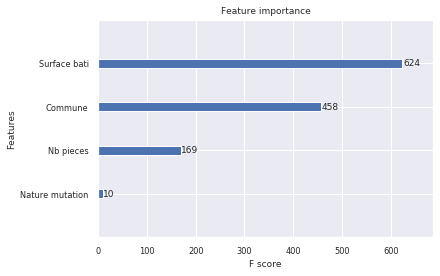

In [629]:
# Importance en "weight"
xgboost.plot_importance(xgb)

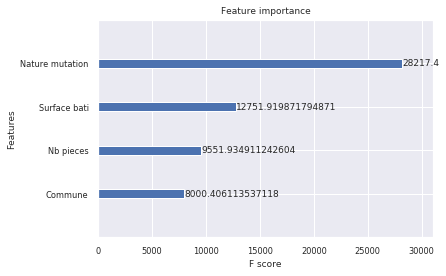

In [630]:
# Importance en "cover"
xgboost.plot_importance(xgb,importance_type="cover")

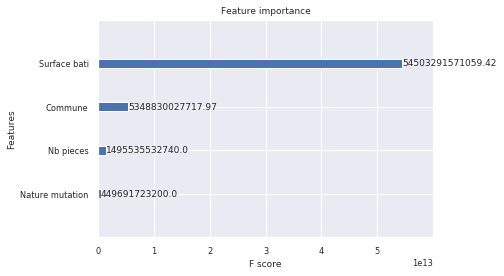

In [631]:
# Importance en "gain"
xgboost.plot_importance(xgb, importance_type="gain")